In [2]:
import pandas as pd
import numpy as np

In [256]:
class Option_pricer:
    def __init__(self, S0, r, q, T, model, params):
        self.S0 = S0
        self.r = r
        self.q = q
        self.T = T
        self.model = model
        self.params = params

    
#Characteristic function
  
    def CF(self, u):
        S0, r, q, T = self.S0, self.r, self.q, self.T
        u = np.array(u, dtype=complex)

        if self.model == 'GBM':
            sigma = self.params[0]
            mu = np.log(S0) + (r - q - 0.5 * sigma**2) * T
            return np.exp(1j * u * mu - 0.5 * (sigma * np.sqrt(T) * u)**2)

        elif self.model == 'Heston':
            kappa, theta, sigma, rho, v0= self.params
            tmp = kappa - 1j * rho * sigma * u
            g = np.sqrt((sigma**2) * (u**2 + 1j*u) + tmp**2)
            pow1 = 2 * kappa * theta / sigma**2
            term1 = (kappa * theta * T * tmp) / sigma**2 + 1j * u * (np.log(S0) + (r - q)*T)
            term2 = pow1 * np.log(np.cosh(g*T/2) + (tmp/g)*np.sinh(g*T/2))
            term3 = ((u**2 + 1j*u) * v0) / (g/np.tanh(g*T/2) + tmp)
            return np.exp(term1 - term2 - term3)

        elif self.model == 'VG':
            sigma, nu, theta = self.params
            if nu == 0:
                mu = np.log(S0) + (r - q - theta - 0.5*sigma**2) * T
                return np.exp(1j * u * mu + (1j*theta*u - 0.5*sigma**2*u**2)*T)
            else:
                mu = np.log(S0) + (r - q + np.log(1 - theta*nu - 0.5*sigma**2*nu)/nu) * T
                return np.exp(1j * u * mu) * (1 - 1j*theta*nu*u + 0.5*nu*sigma**2*u**2) ** (-T/nu)

 
# FFT pricing
    
    def price_fft(self, K, alpha=alpha, eta=eta, n=n):
        N = 2**n
        df = np.exp(-self.r*self.T)
        lda = 2*np.pi/(N*eta)
        beta = np.log(K)

        nu = np.arange(N)*eta
        denom = (alpha + 1j*nu)*(alpha + 1 + 1j*nu)
        psi = self.CF(nu - 1j*(alpha+1)) / denom

        w = np.full(N, eta)
        w[0] = eta/2
        x = df * psi * w * np.exp(-1j*beta*nu)

        y = np.fft.fft(x)
        km = beta + np.arange(N)*lda
        cT = np.exp(-alpha*km) * np.real(y)/np.pi

        return km, cT

   
# Direct integration pricing
    
    def price_integral(self, K, alpha=alpha, eta=eta, n=n):
        N = 2**n
        df = np.exp(-self.r*self.T)
        k = np.log(K)

        nu = np.arange(N)*eta
        denom = (alpha + 1j*nu)*(alpha + 1 + 1j*nu)
        psi = df * self.CF(nu - 1j*(alpha+1)) / denom

        w = np.full(N, eta)
        w[0] = eta/2
        integral = np.sum(np.exp(-1j*nu*k) * psi * w)
        return np.real(np.exp(-alpha*k) * integral / np.pi)

    



In [258]:


S0 = 100
K = 120
r = 0.05
q = 0.01
T = 365 / 365
alpha = 1.5
eta = 0.25
n = 12

params = [0.30]

pricer = Option_pricer(S0, r, q, T, 'GBM', params)

km, prices_fft = pricer.price_fft(K, alpha, eta, n)
call_fft_price = prices_fft[0]


call_int_price = pricer.price_integral(K, alpha, eta, n)


print(f'                spot price : {S0:.4f} ')
print('=====================================')
print(f'                     Model : {pricer.model}')
print(f'      Call Price using FFT : {call_fft_price:.4f}')
print(f' Call Price using Integral : {call_int_price:.4f}')


                spot price : 100.0000 
                     Model : GBM
      Call Price using FFT : 6.5267
 Call Price using Integral : 6.5267


In [262]:
params = [2.0, 0.09, 0.40, -0.70, 0.14]

pricer = Option_pricer(S0, r, q, T, 'Heston', params)

km, prices_fft = pricer.price_fft(K, alpha, eta, n)
call_fft_price = prices_fft[0]

call_int_price = pricer.price_integral(K, alpha, eta, n)

print(f'                spot price : {S0:.4f} ')
print('=====================================')
print(f'                     Model : {pricer.model}')
print(f'      Call Price using FFT : {call_fft_price:.4f}')
print(f' Call Price using Integral : {call_int_price:.4f}')

                spot price : 100.0000 
                     Model : Heston
      Call Price using FFT : 6.6459
 Call Price using Integral : 6.6459


In [264]:
params = [0.30, 0.5, 0.070]

pricer = Option_pricer(S0, r, q, T, 'VG', params)

km, prices_fft = pricer.price_fft(K, alpha, eta, n)
call_fft_price = prices_fft[0]

call_int_price = pricer.price_integral(K, alpha, eta, n)

print(f'                spot price : {S0:.4f} ')
print('=====================================')
print(f'                     Model : {pricer.model}')
print(f'      Call Price using FFT : {call_fft_price:.4f}')
print(f' Call Price using Integral : {call_int_price:.4f}')

                spot price : 100.0000 
                     Model : VG
      Call Price using FFT : 7.1021
 Call Price using Integral : 7.1021


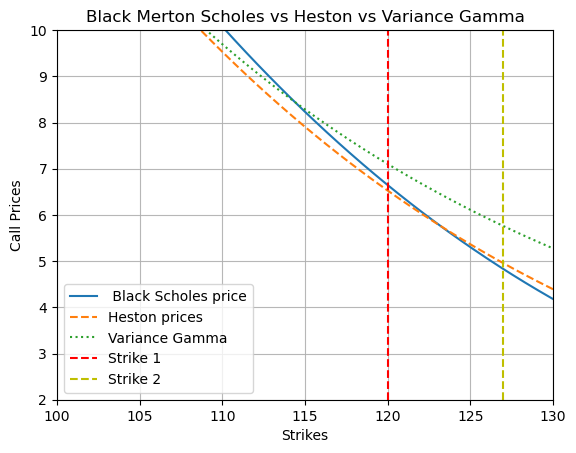

In [266]:
import matplotlib.pyplot as plt

alpha = 1.5
eta = 0.25
n = 12
K1 = 80
strike_2 = 127

params = [2.0, 0.09, 0.40, -0.70, 0.14]
params1 = [0.3]
params2 = [0.30, 0.5, 0.070]

pricer = Option_pricer(S0, r, q, T, 'Heston', params)
pricer1 = Option_pricer(S0, r, q, T, 'GBM', params1)
pricer2 = Option_pricer(S0, r, q, T, 'VG', params2)

km, prices_heston = pricer.price_fft(K = K1, alpha = alpha, eta = eta, n=n)
km, prices_gbm = pricer1.price_fft(K = K1, alpha = alpha, eta = eta, n = n)
km, prices_vg = pricer2.price_fft(K = K1, alpha = alpha, eta = eta, n = n)

K_grid = np.exp(km)

plt.plot(K_grid, prices_heston, label = ' Black Scholes price')
plt.plot(K_grid, prices_gbm, label = 'Heston prices', linestyle = '--')
plt.plot(K_grid, prices_vg, label = 'Variance Gamma', linestyle = ':')

plt.title('Black Merton Scholes vs Heston vs Variance Gamma')
plt.xlabel('Strikes')
plt.ylabel('Call Prices')
plt.axvline(K, color = 'r', label = 'Strike 1', linestyle = '--')
plt.axvline(strike_2, color = 'y', label = 'Strike 2', linestyle = '--')
plt.xlim(100, 130)
plt.ylim(2, 10)
plt.grid(alpha = 0.9)
plt.legend()
plt.show()



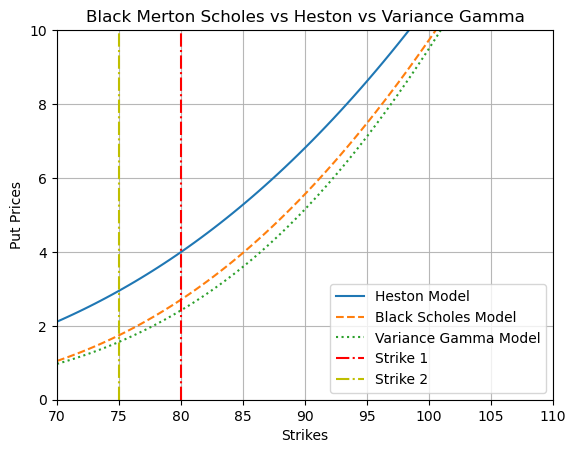

In [288]:
### USE alpha<-1 to compute the Put Prices in FFT and Integral Models  

S0 = 100
K = 80
r = 0.05
q = 0.01
T = 365 / 365
alpha = -1.5
eta = 0.25
n = 12

K_p = 70
strike_2 = 75

params = [2.0, 0.09, 0.40, -0.70, 0.14]
params1 = [0.3]
params2 = [0.30, 0.5, 0.070]

pricer = Option_pricer(S0, r, q, T, 'Heston', params)
pricer1 = Option_pricer(S0, r, q, T, 'GBM', params1)
pricer2 = Option_pricer(S0, r, q, T, 'VG', params2)

km, prices_heston = pricer.price_fft(K = K_p, alpha = alpha, eta = eta, n=n)
km, prices_gbm = pricer1.price_fft(K = K_p, alpha = alpha, eta = eta, n = n)
km, prices_vg = pricer2.price_fft(K = K_p, alpha = alpha, eta = eta, n = n)

K_grid = np.exp(km)

plt.plot(K_grid, prices_heston, label = 'Heston Model')
plt.plot(K_grid, prices_gbm, label = 'Black Scholes Model', linestyle = '--')
plt.plot(K_grid, prices_vg, label = 'Variance Gamma Model', linestyle = ':')

plt.title('Black Merton Scholes vs Heston vs Variance Gamma')
plt.xlabel('Strikes')
plt.ylabel('Put Prices')
plt.axvline(K, color = 'r', label = 'Strike 1', linestyle = '-.')
plt.axvline(strike_2, color = 'y', label = 'Strike 2', linestyle = '-.')
plt.xlim(70, 110)
plt.ylim(0, 10)
plt.grid(alpha = 0.9)
plt.legend()
plt.show()


In [270]:
S0 = 100
K = 80
r = 0.05
q = 0.01
T = 365 / 365
alpha = -1.5
eta = 0.25
n = 12

price = Option_pricer(S0, r, q, T, 'Heston', params)
km, put_pr = price.price_fft(K = K, alpha = alpha, eta = eta, n=n)
put_price_h = put_pr[0]
put_int_price = price.price_integral(K, alpha, eta, n)  

print(f'                spot price : {S0:.4f} ')
print('=====================================')
print(f'                     Model : {price.model}')
print('-------------------------------------')
print(f'       Put Price using FFT : {put_price_h:.4f}')
print(f'  Put Price using Integral : {put_int_price:.4f}')

                spot price : 100.0000 
                     Model : Heston
-------------------------------------
       Put Price using FFT : 3.9964


In [286]:
price2 = Option_pricer(S0, r, q, T, 'GBM', params1)
km, put_pr2 = price1.price_fft(K = K, alpha = alpha, eta = eta, n=n)
put_price_gbm = put_pr2[0]

print(f'                spot price : {S0:.4f} ')
print('=====================================')
print(f'                     Model : {price2.model}')
print('-------------------------------------')
print(f'       Put Price using FFT : {put_price_gbm:.4f}')

                spot price : 100.0000 
                     Model : GBM
-------------------------------------
       Put Price using FFT : 2.7083


In [284]:
price3 = Option_pricer(S0, r, q, T, 'VG', params2)
km, put_pr3 = price2.price_fft(K = K, alpha = alpha, eta = eta, n=n)
put_price_vg = put_pr3[0]

print(f'                spot price : {S0:.4f} ')
print('=====================================')
print(f'                     Model : {price3.model}')
print('-------------------------------------')
print(f'       Put Price using FFT : {put_price_vg:.4f}')

                spot price : 100.0000 
                     Model : VG
-------------------------------------
       Put Price using FFT : 2.4192
